In [2]:
import os
import random
import sys
sys.path.append("../../")

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from MAPIE.mapie.classification import MapieClassifier

# Global variables

In [3]:
PATH_PICKLES = "../../pickle_files"
PATH_IMAGES = "../../"
MLP_MODEL_SCORE = "../../model_weights/mlp_score.pt"
MLP_MODEL_APS = "../../model_weights/mlp_aps.pt"

EMBEDDINGS_FILE = "embeddings.pickle"
SOFTMAX_FILE = "score_softmax.pickle"

RADOM_STATE = 42


MODEL = "resnet101"

# Get labels and data

In [4]:
def get_labels(path_labels):
    with open(path_labels, 'r') as f:
        content = f.read()

    content = content.split('\n')

    labels = {}
    for l in content :
        labels[l[:9]] = l[9:]

    return labels # [:-1]

labels = get_labels("../../LOC_synset_mapping.txt")

In [5]:
with open(os.path.join(PATH_PICKLES, EMBEDDINGS_FILE), "rb") as f:
    file = pickle.load(f)
    embeddings = file[MODEL]
    image_names = file["image_file"]
with open(os.path.join(PATH_PICKLES, SOFTMAX_FILE), "rb") as f:
    softmax = pickle.load(f)[MODEL]

In [6]:
labels_keys = list(labels.keys())

In [7]:
y = [labels_keys.index(image_name.split('/')[2]) for image_name in image_names]

# Plot images for sanity check

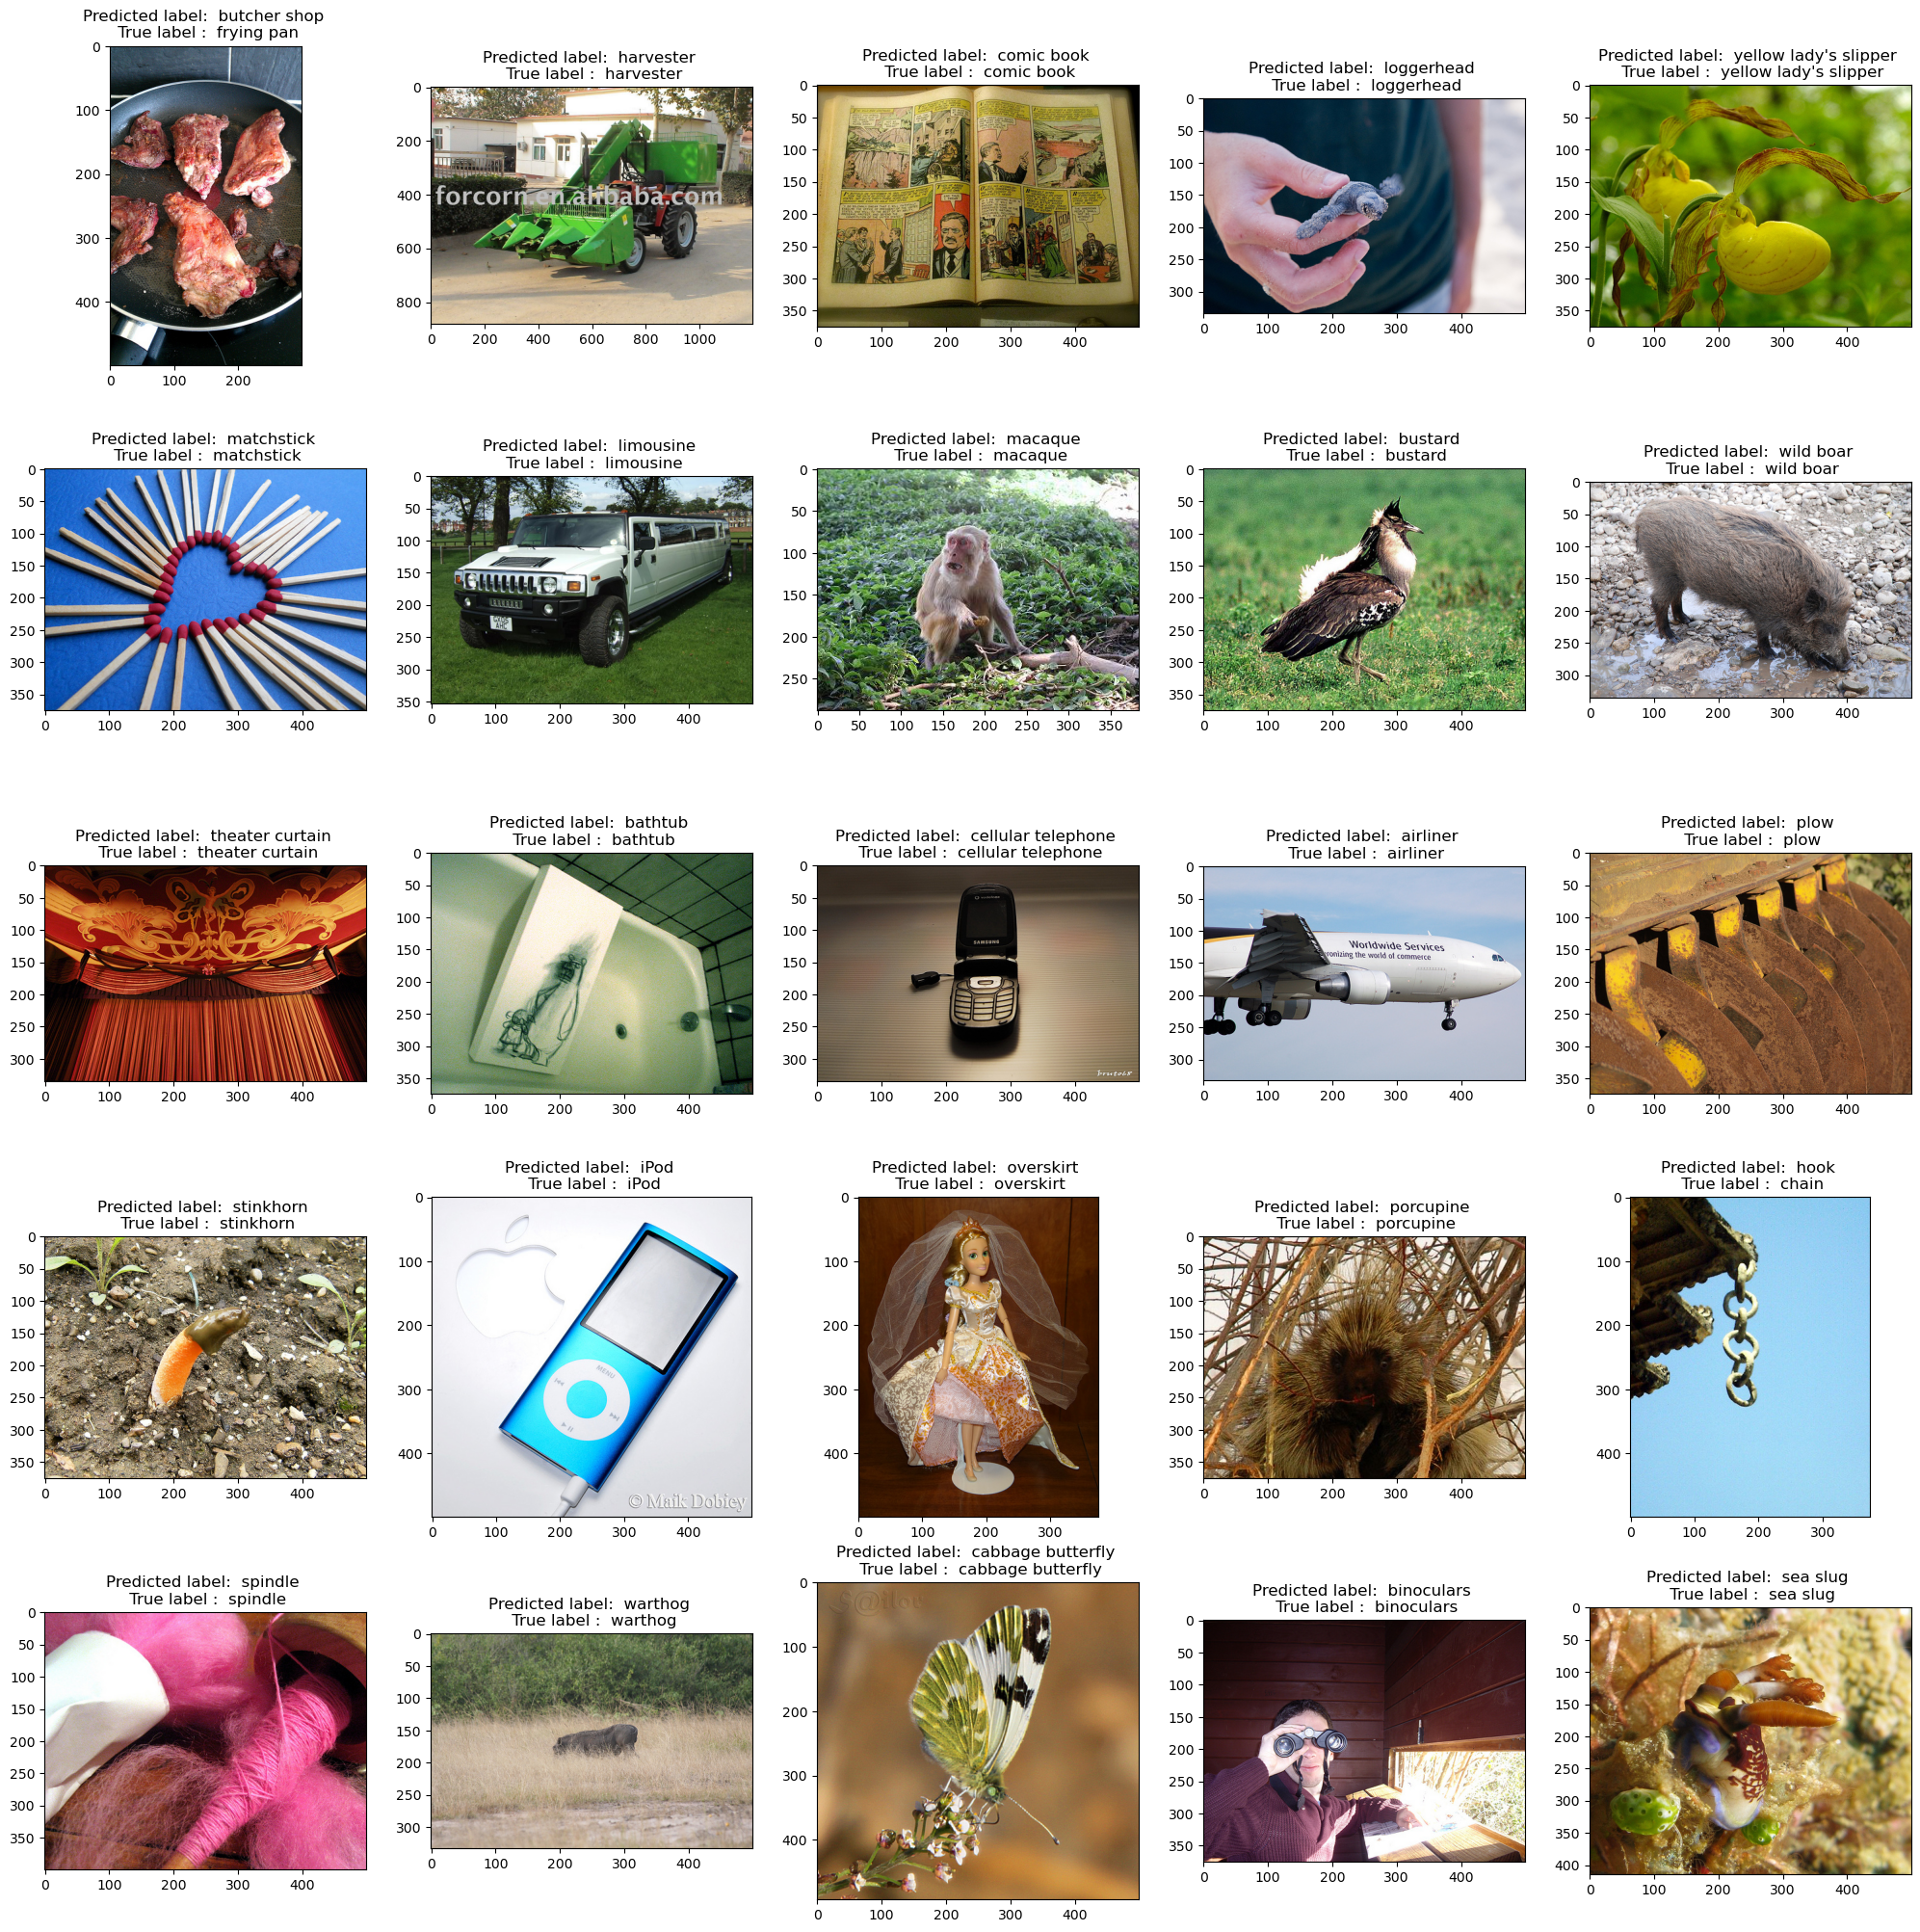

In [8]:
n_rows = 5
n_cols = 5
plot_size = 5

indices_to_plot = random.sample(range(len(image_names)), k=n_rows * n_cols)

f, ax = plt.subplots(n_rows, n_cols, figsize=(n_cols * plot_size, n_rows * plot_size))

count = 0
for i in range(n_rows):
    for j in range(n_cols):
        image_index = indices_to_plot[count]
        image_name = image_names[image_index]
        image = cv2.imread(
            os.path.join(
                PATH_IMAGES,
                image_name
            )
        )
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        label = labels[image_name.split('/')[2]]

        ax[i, j].imshow(image)
        predicted_label_index = np.argmax(softmax[image_index])
        predicted_label_key = labels_keys[predicted_label_index]
        predicted_label = labels[predicted_label_key]
        title = f"Predicted label: {predicted_label.split(',')[0]} \n True label : {label.split(',')[0]}"
        ax[i, j].set_title(title)
        count += 1 


# Define wrapper class for MAPIE

In [9]:
class MapieWrapper():
    def __init__(self):
        self.trained_ = True
        self.classes_ = np.arange(1000)

    def fit(self, X, y=None):
        pass

    def predict_proba(self, X):
        return X

    def predict(self, X):
        pred_proba = self.predict_proba(X)
        pred = np.argmax(pred_proba, axis=1)
        return pred

    def __sklearn_is_fitted__(self):
        return True

# Define residual regressor

In [10]:
class MLP(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Linear(2048, 1024)
        self.layer2 = nn.Linear(1024, 512)
        self.layer3 = nn.Linear(512, 256)
        self.layer4 = nn.Linear(256, 64)
        self.layer5 = nn.Linear(64, 1)
        self.relu = nn.ReLU()

    def forward(self, X):
        out = self.relu(self.layer1(X))
        out = self.relu(self.layer2(out))
        out = self.relu(self.layer3(out))
        out = self.relu(self.layer4(out))
        out = self.relu(self.layer5(out))
        return out
    

In [11]:
def train_mlp(
        model, X, y,
        optimizer, criterion, n_epochs, patience=5,
        device=torch.device("mps")
):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=.2)
    model.to(device)
    best_val_loss = np.inf
    for epoch in range(n_epochs):
        X_train = torch.Tensor(X_train).to(device)
        y_train = torch.Tensor(y_train).to(device)

        optimizer.zero_grad()
        outputs = model(X_train)
        loss = criterion(outputs, y_train)

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            val_outputs = model(torch.tensor(X_val).to(device))
            val_loss = criterion(
                val_outputs,
                torch.tensor(y_val).to(device)
            ).item()
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                best_model_state_dict = model.state_dict()
                print(f'best model saved at epoch {epoch}/{n_epochs}')
                count_patience = 0
            else:
                count_patience += 1
            
            if count_patience >= patience:
                print('The model stopped improving')
                break

        print(f'Epoch {epoch}/{n_epochs} - TRAIN_LOSS: {loss.item():.3f} - VALLOSS: {val_loss:.3f}')

    trained_model = model
    trained_model.load_state_dict(best_model_state_dict)
    return trained_model

# Split data into cal, res and test


In [12]:
def split_res_cal_test(X_soft, X_emb, y, y_res):
    X_soft_temp, X_soft_test, y_temp, y_test = train_test_split(X_soft, y, test_size=1/3, random_state=RADOM_STATE)
    X_emb_temp, X_emb_test, y_res_temp, y_res_test = train_test_split(X_emb, y_res, test_size=1/3, random_state=RADOM_STATE)

    X_soft_cal, _, y_cal, _ = train_test_split(X_soft_temp, y_temp, test_size=.5, random_state=RADOM_STATE)
    X_emb_cal, X_emb_res, y_res_cal, y_res_res = train_test_split(X_emb_temp, y_res_temp, test_size=.5, random_state=RADOM_STATE)

    return (
        (X_emb_res, y_res_res),
        (X_emb_cal, y_res_cal),
        (X_soft_cal, y_cal),
        (X_emb_test, y_res_test),
        (X_soft_test, y_test)
    )


In [13]:
def _get_true_label_cumsum_proba(
    y,
    y_pred_proba,
):
    y_true = label_binarize(y=y, classes=range(1000))
    index_sorted = np.fliplr(np.argsort(y_pred_proba, axis=1))
    y_pred_proba_sorted = np.take_along_axis(y_pred_proba, index_sorted, axis=1)
    y_true_sorted = np.take_along_axis(y_true, index_sorted, axis=1)
    y_pred_proba_sorted_cumsum = np.cumsum(y_pred_proba_sorted, axis=1)
    cutoff = np.argmax(y_true_sorted, axis=1)
    true_label_cumsum_proba = np.take_along_axis(
        y_pred_proba_sorted_cumsum, cutoff.reshape(-1, 1), axis=1
    )
    return true_label_cumsum_proba, cutoff + 1

def get_residuals(y_res, y_pred_proba, method):
    if method == "crf_score":
        y_res_predict_new = np.take_along_axis(
            1 - y_pred_proba, np.expand_dims(y_res, axis=1), axis=1
        )
    elif method == "crf_aps":
        cum_sum_proba = _get_true_label_cumsum_proba(y=y_res, y_pred_proba=y_pred_proba)
        y_res_predict_new = cum_sum_proba[0].ravel()[:, np.newaxis]
    return y_res_predict_new

In [14]:
y_res_score = get_residuals(y_res=y, y_pred_proba=softmax, method='crf_score')
y_res_aps = get_residuals(y_res=y, y_pred_proba=softmax, method='crf_aps')

In [15]:
print(y_res_aps.shape)

(50000, 1)


In [16]:
(
    fit_res_score_dataset,
    cal_res_score_dataset,
    cal_dataset,
    test_res_score_dataset,
    test_dataset
) = split_res_cal_test(softmax, embeddings, y, y_res_score)

In [17]:
(
    fit_res_aps_dataset,
    cal_res_aps_dataset,
    _,
    test_res_aps_dataset,
    _
) = split_res_cal_test(softmax, embeddings, y, y_res_aps)

In [25]:
assert (fit_res_aps_dataset[1].shape == fit_res_score_dataset[1].shape)
assert (cal_res_aps_dataset[1].shape == cal_res_score_dataset[1].shape)
assert (test_res_aps_dataset[1].shape == test_res_score_dataset[1].shape)

assert (cal_res_aps_dataset[0] == cal_res_score_dataset[0]).all()
assert (test_res_aps_dataset[0] == test_res_score_dataset[0]).all()

assert (len(cal_res_score_dataset[0]) == len(cal_dataset[0]))
assert (len(test_res_score_dataset[0]) == len(test_dataset[0]))

# Train residual regressors for Score and APS

In [30]:
score_residual_model = MLP()

score_residual_model = train_mlp(
    score_residual_model,
    fit_res_score_dataset[0],
    fit_res_score_dataset[1],
    optimizer=torch.optim.Adam(score_residual_model.parameters()),
    criterion = nn.MSELoss(),
    n_epochs=100,
    patience=10
)
score_residual_model.cpu()

best model saved at epoch 0/100
Epoch 0/100 - TRAIN_LOSS: 0.225 - VALLOSS: 0.157
best model saved at epoch 1/100
Epoch 1/100 - TRAIN_LOSS: 0.159 - VALLOSS: 0.081
Epoch 2/100 - TRAIN_LOSS: 0.082 - VALLOSS: 0.187
best model saved at epoch 3/100
Epoch 3/100 - TRAIN_LOSS: 0.179 - VALLOSS: 0.080
best model saved at epoch 4/100
Epoch 4/100 - TRAIN_LOSS: 0.079 - VALLOSS: 0.073
Epoch 5/100 - TRAIN_LOSS: 0.074 - VALLOSS: 0.090
Epoch 6/100 - TRAIN_LOSS: 0.091 - VALLOSS: 0.099
Epoch 7/100 - TRAIN_LOSS: 0.100 - VALLOSS: 0.099
Epoch 8/100 - TRAIN_LOSS: 0.099 - VALLOSS: 0.090
Epoch 9/100 - TRAIN_LOSS: 0.091 - VALLOSS: 0.077
best model saved at epoch 10/100
Epoch 10/100 - TRAIN_LOSS: 0.078 - VALLOSS: 0.065
best model saved at epoch 11/100
Epoch 11/100 - TRAIN_LOSS: 0.065 - VALLOSS: 0.065
Epoch 12/100 - TRAIN_LOSS: 0.063 - VALLOSS: 0.078
Epoch 13/100 - TRAIN_LOSS: 0.074 - VALLOSS: 0.080
Epoch 14/100 - TRAIN_LOSS: 0.076 - VALLOSS: 0.069
best model saved at epoch 15/100
Epoch 15/100 - TRAIN_LOSS: 0.066 

MLP(
  (layer1): Linear(in_features=2048, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

In [31]:
aps_residual_model = MLP()

aps_residual_model = train_mlp(aps_residual_model,
          fit_res_aps_dataset[0],
          fit_res_aps_dataset[1],
          optimizer=torch.optim.Adam(aps_residual_model.parameters()),
          criterion = nn.MSELoss(),
          n_epochs=80,
          patience=10)
aps_residual_model.cpu()

best model saved at epoch 0/80
Epoch 0/80 - TRAIN_LOSS: 0.485 - VALLOSS: 0.384
best model saved at epoch 1/80
Epoch 1/80 - TRAIN_LOSS: 0.383 - VALLOSS: 0.220
Epoch 2/80 - TRAIN_LOSS: 0.221 - VALLOSS: 0.378
best model saved at epoch 3/80
Epoch 3/80 - TRAIN_LOSS: 0.385 - VALLOSS: 0.177
best model saved at epoch 4/80
Epoch 4/80 - TRAIN_LOSS: 0.180 - VALLOSS: 0.171
Epoch 5/80 - TRAIN_LOSS: 0.172 - VALLOSS: 0.196
Epoch 6/80 - TRAIN_LOSS: 0.195 - VALLOSS: 0.188
best model saved at epoch 7/80
Epoch 7/80 - TRAIN_LOSS: 0.187 - VALLOSS: 0.147
best model saved at epoch 8/80
Epoch 8/80 - TRAIN_LOSS: 0.146 - VALLOSS: 0.098
Epoch 9/80 - TRAIN_LOSS: 0.098 - VALLOSS: 0.122
Epoch 10/80 - TRAIN_LOSS: 0.122 - VALLOSS: 0.106
best model saved at epoch 11/80
Epoch 11/80 - TRAIN_LOSS: 0.105 - VALLOSS: 0.071
best model saved at epoch 12/80
Epoch 12/80 - TRAIN_LOSS: 0.069 - VALLOSS: 0.066
Epoch 13/80 - TRAIN_LOSS: 0.063 - VALLOSS: 0.069
best model saved at epoch 14/80
Epoch 14/80 - TRAIN_LOSS: 0.066 - VALLOSS:

MLP(
  (layer1): Linear(in_features=2048, out_features=1024, bias=True)
  (layer2): Linear(in_features=1024, out_features=512, bias=True)
  (layer3): Linear(in_features=512, out_features=256, bias=True)
  (layer4): Linear(in_features=256, out_features=64, bias=True)
  (layer5): Linear(in_features=64, out_features=1, bias=True)
  (relu): ReLU()
)

# MAPIE Calibration

In [36]:
method_params = {
    "naive": ("naive", True),
    "score": ("score", True),
    "cumulated_score": ("cumulated_score", True),
    "raps": ("raps", True),
    "crf_score": ("crf_score", True),
    "crf_aps": ("crf_aps", True),
}

In [37]:
y_preds_all_models, y_pss_all_models = {}, {}
alphas = np.arange(0.1, 1, .1)
mapie_model = MapieWrapper()
y_preds, y_pss = {}, {}
for method_name, (method, include_last_label) in method_params.items():
    print(method_name)
    mapie = MapieClassifier(mapie_model, method=method, cv="prefit", random_state=42)
    if method == "crf_score":
        y_cal_res_score_pred = score_residual_model(
            torch.tensor(cal_res_score_dataset[0])
        ).detach().numpy()[:, 0]
        y_test_res_score_pred = score_residual_model(
            torch.tensor(test_res_score_dataset[0])
        ).detach().numpy()[:, 0]
        mapie.fit(cal_dataset[0], cal_dataset[1], residuals=y_cal_res_score_pred)
        y_preds[method_name], y_pss[method_name] = mapie.predict(
            test_dataset[0],
            alpha=alphas,
            include_last_label=include_last_label,
            residuals=y_test_res_score_pred
        )
    elif method == "crf_aps":
        y_cal_res_aps_pred = aps_residual_model(
            torch.tensor(cal_res_aps_dataset[0])
        ).detach().numpy()[:, 0]
        y_test_res_aps_pred = aps_residual_model(
            torch.tensor(test_res_aps_dataset[0])
        ).detach().numpy()[:, 0]
        mapie.fit(cal_dataset[0], cal_dataset[1], residuals=y_cal_res_aps_pred)
        y_preds[method_name], y_pss[method_name] = mapie.predict(
            test_dataset[0],
            alpha=alphas,
            include_last_label=include_last_label,
            residuals=y_test_res_aps_pred
        )
    else:   
        mapie.fit(cal_dataset[0], cal_dataset[1])
        y_preds[method_name], y_pss[method_name] = mapie.predict(test_dataset[0], alpha=alphas, include_last_label=include_last_label)


naive
score
cumulated_score
raps
crf_score
crf_aps
